# Maxcut problem

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


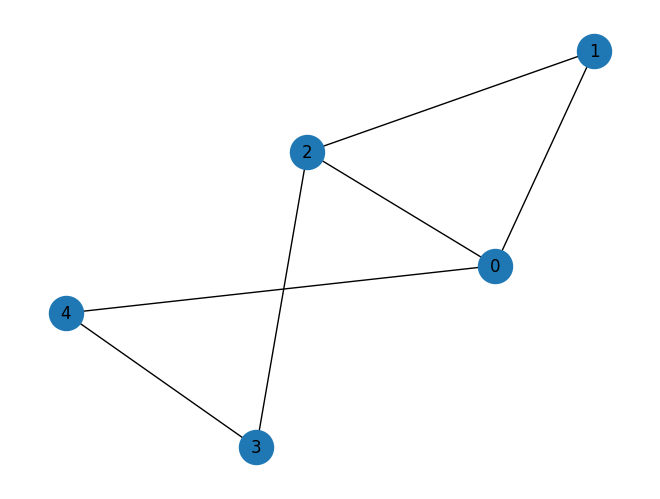

In [2]:
from maxcut import build_max_cut_paulis, create_graph
from qiskit.quantum_info import SparsePauliOp

n = 5

graph = create_graph(n)

max_cut_paulis = build_max_cut_paulis(graph)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

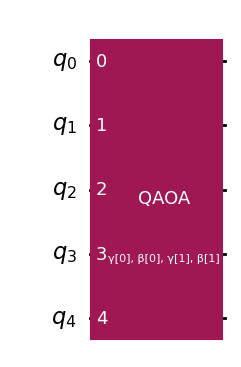

In [12]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
# circuit.measure_all()

circuit.draw('mpl')

In [13]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])

In [14]:
# from qiskit_ibm_runtime import QiskitRuntimeService
# from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


# # QiskitRuntimeService.save_account(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>", overwrite=True, set_as_default=True)
# service = QiskitRuntimeService(channel='ibm_quantum')
# backend = service.least_busy(min_num_qubits=127)
# print(backend)

# # Create pass manager for transpilation
# pm = generate_preset_pass_manager(optimization_level=3,
#                                     backend=backend)

# candidate_circuit = pm.run(circuit)
# candidate_circuit.draw('mpl', fold=False, idle_wires=False)

In [15]:
import numpy as np

initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta, initial_gamma, initial_beta]

In [16]:
objective_func_vals = [] # Global variable

def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

In [17]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize

# with Session(backend=backend) as session:
#     # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
#     estimator = Estimator(mode=session)
#     estimator.options.default_shots = 1000

#     # Set simple error suppression/mitigation options
#     estimator.options.dynamical_decoupling.enable = True
#     estimator.options.dynamical_decoupling.sequence_type = "XY4"
#     estimator.options.twirling.enable_gates = True
#     estimator.options.twirling.num_randomizations = "auto"

#     result = minimize(
#         cost_func_estimator,
#         init_params,
#         args=(candidate_circuit, cost_hamiltonian, estimator),
#         method="COBYLA",
#         tol=1e-2,
#     )
#     print(result)

from qiskit.primitives import StatevectorEstimator as Estimator

estimator = Estimator()

result = minimize(
    cost_func_estimator,
    init_params,
    args=(circuit, cost_hamiltonian, estimator),
    method="COBYLA",
    tol=1e-2,
)

print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.841335988333283
       x: [ 3.335e+00  2.850e+00  2.737e+00  8.227e-01]
    nfev: 44
   maxcv: 0.0


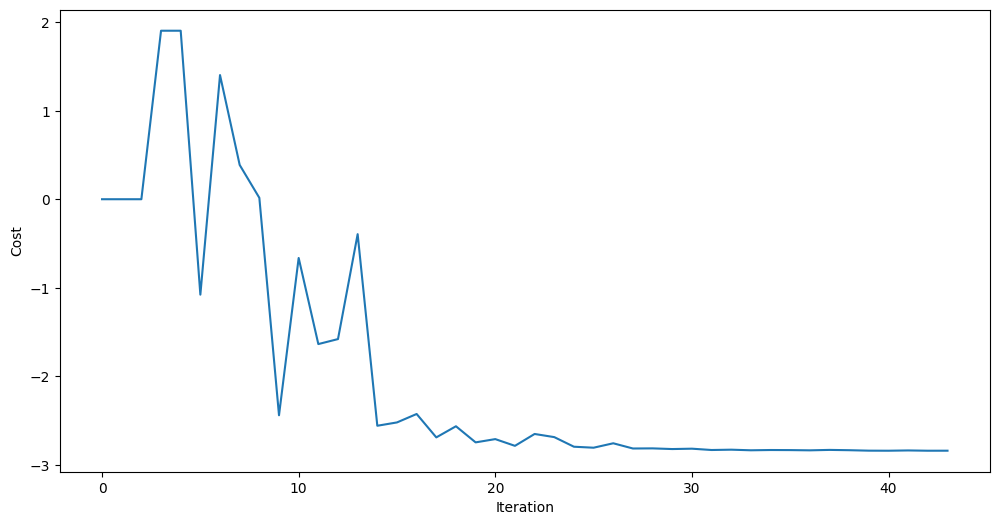

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

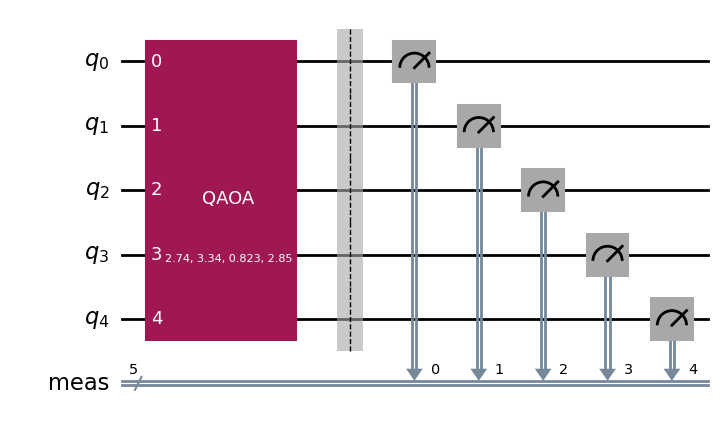

In [19]:
optimized_circuit = circuit.assign_parameters(result.x)
optimized_circuit.measure_all()
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [ ]:
# from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.primitives import StatevectorSampler as Sampler

# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(shots=10000)
# sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
# sampler.options.dynamical_decoupling.enable = True
# sampler.options.dynamical_decoupling.sequence_type = "XY4"
# sampler.options.twirling.enable_gates = True
# sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)